In [3]:
import warnings
import pandas as pd
pd.set_option('display.max_columns', 15)
warnings.filterwarnings('ignore')

data = pd.read_csv('train.csv')
print(f'data = {data.shape}')
data.head(2)

data = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,...,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,...,NaN,0,5,2007,WD,Normal,181500


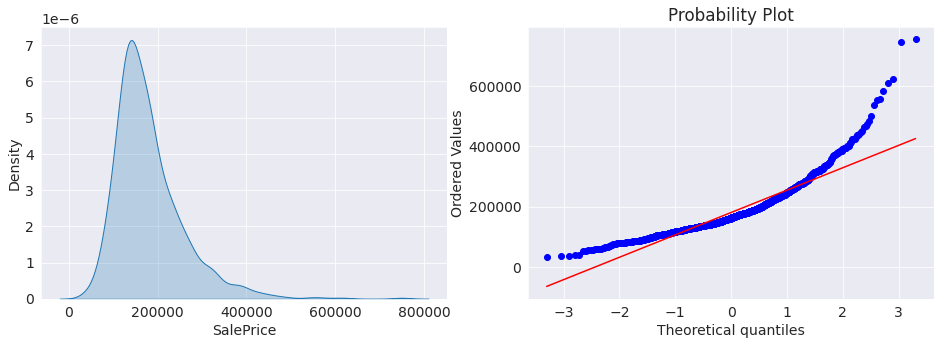

In [5]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rc('font', size=14)

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(16, 5)

sns.kdeplot(
    data=data, x='SalePrice', shade=True, 
    ax=ax1
)
sp.stats.probplot(
    data.SalePrice, 
    plot=ax2
)
plt.show()

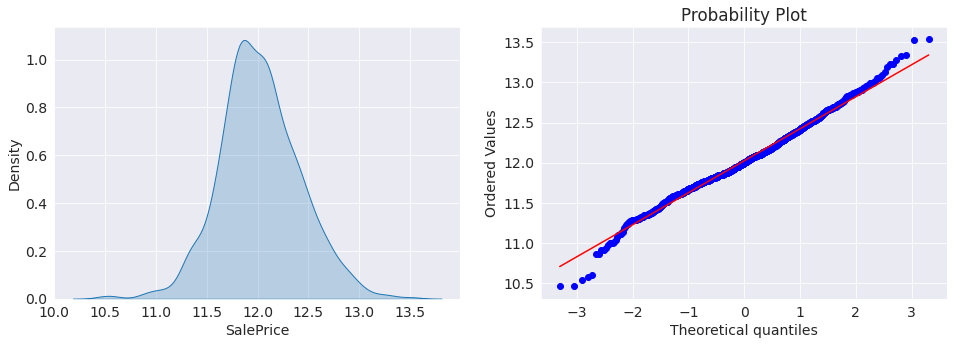

In [7]:
import numpy as np

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(16, 5)

data['SalePrice'] = data.SalePrice.apply(
    lambda x: np.log1p(x)
)

sns.kdeplot(
    data=data, x='SalePrice', shade=True, 
    ax=ax1
)
sp.stats.probplot(
    data.SalePrice, 
    plot=ax2
)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

x_data = data.copy()
x_data = pd.get_dummies(
    x_data, dummy_na=True
).dropna(axis=0)

y_data = x_data.pop('SalePrice')

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=27
)
print(f'xy_train.shape = {x_train.shape}, {y_train.shape}')
x_train.head(2)

xy_train.shape = (784, 332), (784,)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
834,835,20,75.0,7875,5,6,1961,...,0,0,0,0,1,0,0
1393,1394,190,60.0,10800,6,7,1905,...,0,0,0,0,1,0,0


In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=30)

selector.fit_transform(x_train, y_train)

selected_mask = selector.get_support()
all_columns = x_train.columns

selected_features = all_columns[selected_mask]

pd.DataFrame(
    list(feature.split('_') for feature in selected_features), 
    columns=['ImportantFeature', 'ImportantValue']
)

,ImportantFeature,ImportantValue
0,OverallQual,None
1,YearBuilt,None
2,YearRemodAdd,None
3,MasVnrArea,None
4,TotalBsmtSF,None
5,1stFlrSF,None
6,GrLivArea,None
7,FullBath,None
8,TotRmsAbvGrd,None
9,Fireplaces,None


In [79]:
AutoSklearnRegressor?

In [ ]:
!pip install auto-sklearn

In [81]:
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import root_mean_squared_error

find_minutes = 5

automl = AutoSklearnRegressor(
    load_models=True,
    time_left_for_this_task=60*find_minutes,
    resampling_strategy='cv'
    metric=root_mean_squared_error,
    ensemble_size=3,
    memory_limit=10**4,
    seed=27,
)
automl.fit(
    x_train[selected_features], 
    y_train
)

y_pred = automl.predict(
    x_test[selected_features]
)
val_score = root_mean_squared_error(
    y_test, y_pred
)
print(f'val_score = {-val_score}')

print(automl.leaderboard())

val_score = 0.1362895442465328
          rank  ensemble_weight            type      cost   duration
model_id                                                            
11           1         0.666667  ard_regression  0.160168   2.205669
2            2         0.333333   random_forest  0.160697  11.943477


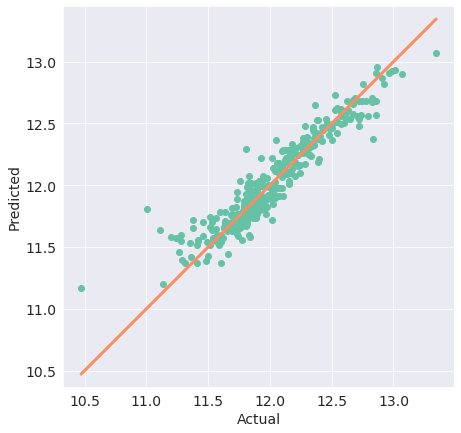

In [83]:
plt.figure(figsize=(7, 7))

point_color, line_color = sns.color_palette('Set2', 2)

plt.scatter(
    y_test, y_pred, 
    color=point_color
)

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))

plt.plot(
    [p1, p2], [p1, p2], 
    color=line_color, linewidth=3
)

plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.axis('equal')

plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer

arr_val_score = cross_val_score(
    pipeline,
    df_train_x, df_train_y,
    cv=3,
    scoring=make_scorer(mean_squared_log_error, greater_is_better=False)
)
print(f'val_score: mean_squared_log_error = {-np.round(arr_val_score.mean(), 3)}')

pipeline.fit(df_train_x, df_train_y)

df_pred_y = pipeline.predict(df_test_x)

num_test_score = mean_squared_log_error(df_test_y, df_pred_y)
print(f'test_score: mean_squared_log_error = {np.round(num_test_score, 3)}')

In [ ]:
from sklearn import set_config
from sklearn.pipeline import Pipeline
set_config(display='diagram')

p = [p1, p2, p3]
pipeline = Pipeline(p)

display(pipeline)

In [ ]:

from sklearn.model_selection import RandomizedSearchCV, KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=27)

param_grid = {
    'model': [RandomForestRegressor(random_state=27)],
    'model__max_depth': np.linspace(1, 16, 16),
    'model__n_estimators': np.arange(100, 500, 100),
    'model__max_leaf_nodes': [16, 64, 128, 256],
    'model__oob_score': [True],
}
scoring = {
    'mean_squared_log_error': make_scorer(
        mean_squared_log_error, greater_is_better=False
    ),
    'mean_squared_error': 'neg_mean_squared_error'
}

n_iter = 10

grid = RandomizedSearchCV(
    estimator=pipeline, 
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit='mean_squared_log_error',
    n_iter=n_iter,
    n_jobs=-1,
    random_state=27,
)
grid.fit(df_train_x, df_train_y)

print(f'best_score: mean_squared_log = {-np.round(grid.best_score_, 3)}')

best_model = grid.best_params_['model']
display(best_model)

In [ ]:
import missingno as msno

In [ ]:
 auto-sklearn==0.15.0